# Importing all the libraries

In [140]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [141]:
# Loading Dataset in a variable
df = pd.read_csv('Problem_Dataset.csv')

In [142]:
# we will save Obs and Type column respectively
X = df['Obs'].values
y = df['Type'].values

In [143]:
# Converting Strings labels to Integer
label_encoder = LabelEncoder()
y_encode = label_encoder.fit_transform(y)
# calculating number of classes i.e number of labels which will be further use for encoding
num_classes = len(label_encoder.classes_)
print(num_classes)

7


In [144]:
# Splitting data in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encode, test_size=0.2, random_state=42)

In [145]:
# here tokenizer is used to convert the sentences in X_train to numeric values for every word
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [146]:
# here padding is done so that the variable words in sentences can be made of same size
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train_seq)
X_val_padded = keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=X_train_padded.shape[1])

In [147]:
# Performing one hot encoding, as we are working with binary we will convert all the labels in binary and store them as one's and zero's
y_train_oneHot = to_categorical(y_train, num_classes=num_classes)
y_val_oneHot = to_categorical(y_val, num_classes=num_classes)

# Binary Classification

In [148]:
models = {}

for label in label_encoder.classes_:
    # Define the model architecture (adjust as needed)
    model = keras.Sequential([
        layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_train_padded.shape[1]),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

In [149]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train_oneHot, validation_data=(X_val_padded, y_val_oneHot), epochs=5, batch_size=32, verbose=2)

models[label] = model

Epoch 1/5
27/27 - 4s - loss: 1.9351 - accuracy: 0.2036 - val_loss: 1.9099 - val_accuracy: 0.1286 - 4s/epoch - 140ms/step
Epoch 2/5
27/27 - 0s - loss: 1.7715 - accuracy: 0.2310 - val_loss: 1.6636 - val_accuracy: 0.3048 - 472ms/epoch - 17ms/step
Epoch 3/5
27/27 - 0s - loss: 1.3437 - accuracy: 0.4738 - val_loss: 1.2891 - val_accuracy: 0.5476 - 495ms/epoch - 18ms/step
Epoch 4/5
27/27 - 1s - loss: 0.8279 - accuracy: 0.7226 - val_loss: 0.9083 - val_accuracy: 0.6905 - 924ms/epoch - 34ms/step
Epoch 5/5
27/27 - 1s - loss: 0.4261 - accuracy: 0.8690 - val_loss: 0.7428 - val_accuracy: 0.7381 - 538ms/epoch - 20ms/step


In [110]:
# Evaluating the models *
for label, model in models.items():
    y_val_pred_oneHot = model.predict(X_val_padded)
    y_val_pred = label_encoder.inverse_transform(y_val_pred_oneHot.argmax(axis=1))
    y_val_true = label_encoder.inverse_transform(y_val)

    accuracy = accuracy_score(y_val_true, y_val_pred)
    report = classification_report(y_val_true, y_val_pred,output_dict=True)

7/7 [==============================] - 0s 6ms/step


In [111]:
# print(f"Label: {label}")
# print(f"Validation Accuracy: {accuracy:.4f}")
# print(f"Classification Report:\n{report}")
# print("="*40)

In [160]:
report_df = pd.DataFrame(report).transpose()
# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_Binary.csv', index=True)

predictions_df = pd.DataFrame(y_val_pred, columns=label_encoder.classes_)
predictions_df.to_csv('Binary_predictions.csv', index=False)

# Multilabel Classification Model

In [150]:
X = df['Obs'].values
y = df['Type'].apply(lambda x: x.split(','))  # Assuming labels are comma-separated strings
label_binarizer = MultiLabelBinarizer()
y_encoded = label_binarizer.fit_transform(y)
num_classes = len(label_binarizer.classes_)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences to ensure consistent length
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train_seq)
X_val_padded = keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=X_train_padded.shape[1])

In [151]:
model = keras.Sequential([
    layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_train_padded.shape[1]),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
])

In [152]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
X_val_padded = keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=X_train_padded.shape[1])
# Train the model with early stopping
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
y_val_pred = model.predict(X_val_padded)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

Epoch 1/10
27/27 [==============================] - 3s 32ms/step - loss: 0.6010 - accuracy: 0.1417 - val_loss: 0.4465 - val_accuracy: 0.1238
Epoch 2/10
27/27 [==============================] - 0s 14ms/step - loss: 0.4163 - accuracy: 0.1381 - val_loss: 0.4092 - val_accuracy: 0.1667
Epoch 3/10
27/27 [==============================] - 0s 13ms/step - loss: 0.4085 - accuracy: 0.1690 - val_loss: 0.4057 - val_accuracy: 0.1619
Epoch 4/10
27/27 [==============================] - 0s 15ms/step - loss: 0.3976 - accuracy: 0.2512 - val_loss: 0.3836 - val_accuracy: 0.3619
Epoch 5/10
27/27 [==============================] - 0s 14ms/step - loss: 0.3528 - accuracy: 0.3881 - val_loss: 0.3520 - val_accuracy: 0.3238
Epoch 6/10
27/27 [==============================] - 0s 14ms/step - loss: 0.3104 - accuracy: 0.4762 - val_loss: 0.3111 - val_accuracy: 0.5381
Epoch 7/10
27/27 [==============================] - 0s 14ms/step - loss: 0.2617 - accuracy: 0.7036 - val_loss: 0.2716 - val_accuracy: 0.5571
Epoch 8/10
27

In [153]:
report = classification_report(y_val, y_val_pred_binary, target_names=label_binarizer.classes_,output_dict=True)
# print("Classification Report:\n", report)

C:\Users\ual-laptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [161]:
report_df = pd.DataFrame(report).transpose()
# Save the DataFrame to a CSV file
report_df.to_csv('classification_report_Multi.csv', index=True)

predictions_df = pd.DataFrame(y_val_pred_binary, columns=label_binarizer.classes_)
predictions_df.to_csv('multiLabel_predictions.csv', index=False)

# BERT Model (Some Issues) *

In [89]:
# Tokenize the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_encoded = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)
X_val_encoded = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)

In [90]:
# Load pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
# # Compile the model
# bert_model.compile(optimizer=Adam(learning_rate=2e-5),
#                    loss=BinaryCrossentropy(),
#                    metrics=[BinaryAccuracy()])

# # Training the model with early stopping
# early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
# bert_model.fit(X_train_encoded, y_train, validation_data=(X_val_encoded, y_val), epochs=5, batch_size=32, callbacks=[early_stopping])

# # Evaluating the model
# y_val_pred_logits = bert_model.predict(X_val_encoded)
# y_val_pred = tf.sigmoid(y_val_pred_logits).numpy()
# y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# # Reporting precision, recall, F1-score
# report = classification_report(y_val, y_val_pred_binary, target_names=label_binarizer.classes_)
# print("Classification Report:\n", report)

# Plotting all the seven labels for Precision, Recall and F1-Score

## Binary Clasification Plots

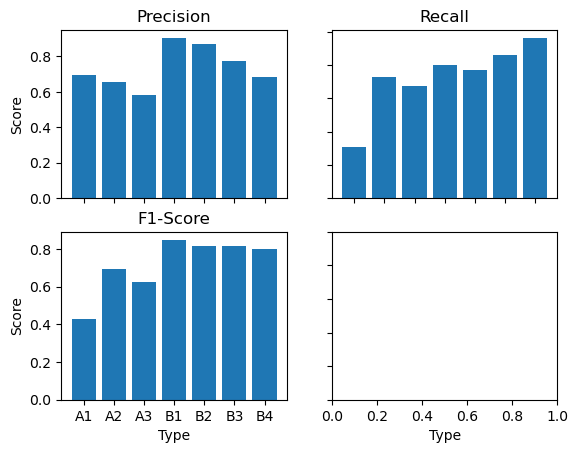

In [135]:
report_binary = pd.read_csv('classification_report_Binary.csv') 
  
df = pd.DataFrame(report_binary) 
  
X = list(df.iloc[:, 0]) 
Y = list(df.iloc[:, 1])

X1 = list(df.iloc[:, 0]) 
Y1 = list(df.iloc[:, 2])

X2 = list(df.iloc[:, 0]) 
Y2 = list(df.iloc[:, 3])
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(X, Y)
axs[0, 0].set_title("Precision")
axs[0, 1].bar(X1, Y1)
axs[0, 1].set_title("Recall")
axs[1, 0].bar(X2, Y2)
axs[1, 0].set_title("F1-Score")

for ax in axs.flat:
    ax.set(xlabel='Type', ylabel='Score')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Multilabel Classification Plots

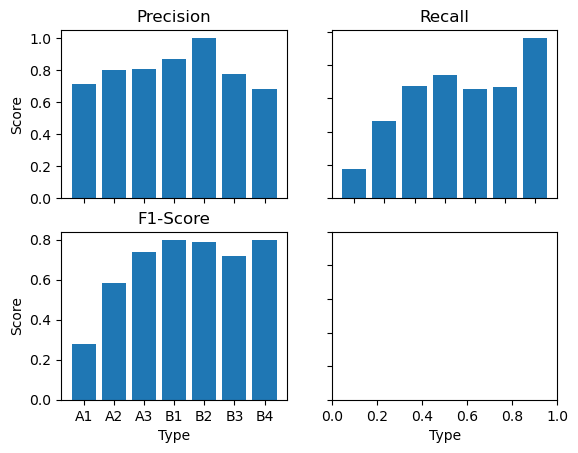

In [156]:
report_binary = pd.read_csv('classification_report_Multi.csv') 
  
df = pd.DataFrame(report_binary) 
  
X = list(df.iloc[:, 0]) 
Y = list(df.iloc[:, 1])

X1 = list(df.iloc[:, 0]) 
Y1 = list(df.iloc[:, 2])

X2 = list(df.iloc[:, 0]) 
Y2 = list(df.iloc[:, 3])
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(X, Y)
axs[0, 0].set_title("Precision")
axs[0, 1].bar(X1, Y1)
axs[0, 1].set_title("Recall")
axs[1, 0].bar(X2, Y2)
axs[1, 0].set_title("F1-Score")

for ax in axs.flat:
    ax.set(xlabel='Type', ylabel='Score')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()